# Classification of Molecular Dynamics Simulations Data

<a rel="license" href="https://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons Licence" style="width=50" src="https://licensebuttons.net/l/by-nc-sa/4.0/88x31.png" title='This work is licensed under a Creative Commons Attribution 4.0 International License.' align="right"/></a>

**Authors**: Dr Matteo Degiacomi (matteo.t.degiacomi@durham.ac.uk) and Dr Antonia Mey (antonia.mey@ed.ac.uk)

**Learning Objectives**:
* Using MDAnalysis to extract features from molecular dynamics simulations featuring different states,
* Using scikit-learn to classify conformations in different states according to the extracted features.

**Jupyter cheat sheet**:
* to run the currently highlighted cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
* to get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;

## Google Colab setup

<div class="alert alert-warning">
<b>Attention:</b> Please only run the following cells if you are using Colab! These cells install necessary packages and download data.</div>

In [ ]:
!if [ -n "$COLAB_RELEASE_TAG" ]; then pip install condacolab; fi
import condacolab
condacolab.install()

import condacolab
!mamba install -c conda-forge mdanalysis mdanalysistests mdanalysisdata nglview scikit-learn ipywidgets=7.6.0

In [ ]:
# enable third party jupyter widgets
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
!if [ -n "$COLAB_RELEASE_TAG" ]; then git clone https://github.com/CCPBioSim/CCP5_Simulation_of_BioMolecules; fi
import os
os.chdir(f"CCP5_Simulation_of_BioMolecules{os.sep}8_Analysis_classification")

## 1. Introduction

To get started with this tutorial, let's importing some packages.

In [1]:
from copy import deepcopy
import os

import numpy as np
import matplotlib.pyplot as plt
import nglview as nv

import MDAnalysis as mda

import warnings
warnings.filterwarnings("ignore")

In this tutorial we will use again the simulation of the protein MurD, presented in our second Jupyter notebook on [dimensionality reduction](../4_Analysis_DR_clustering/2_DR_part2.ipynb). Let's start by loading the downsampled trajectories of its closed (PDB: [3UAG](https://www.rcsb.org/structure/3UAG)) and open (PDB: [1E0D](https://www.rcsb.org/structure/1E0D)) states. Both simulation data are 140 ns-long with a step size of 0.2 ns, and feature only backbone atoms of residues 7-436.

In [2]:
folder = f"..{os.sep}data{os.sep}" # this is the path where the three simulations are located

In [3]:
universe_closed = mda.Universe(f'{folder}MurD_closed_backbone.pdb')

In [4]:
universe_open = mda.Universe(f'{folder}MurD_open_backbone.pdb')

By taking the closed conformation and manually removing the ligand, the protein switches to an open conformation. This is the simulation we want to classify. We will load 100 ns sampled every 0.2 ns (same atom selection as above).

In [5]:
universe_closed_apo = mda.Universe(f'{folder}MurD_closed_apo_backbone.pdb')
w = nv.show_mdanalysis(universe_closed_apo)
w

NGLWidget(max_frame=499)

Our objective in this exercise is to assign the conformations of the latter simulation to either the closed or the open state. We will achieve this goal by training a classification algorithm.

## 2. Setup of feature extraction tools

The class `Featurizer` implements different ways of extracting features from a simulation using MDAnalysis. We have met this class in the previous exercise on dimensionality reduction. Run this cell as-is.

In [6]:
from MDAnalysis.analysis.dihedrals import Ramachandran
from MDAnalysis.analysis import distances

class Featurizer(object):
    
    def __init__(self, feature):
        '''Featurizer class for extracting MD features with MDAnalysis
        Parameters:
        -----------
        feature : String
            name of feature
        '''
        if feature == "ramachandran":
            self.get_features = self._get_features_ramachandran
        elif feature == "distance matrix":    
            self.get_features = self._get_features_distance_matrix
        elif feature == "coordinates":    
            self.get_features = self._get_features_coordinates
        elif feature == "custom":
            self.get_features = self._get_features_custom
        else:
            raise Exception("Features extraction method %s not recognised"%feature)
            
        self.feature = feature
 
    
    def _get_features_coordinates(self, universe):
        '''
        alpha carbons coordinates
        '''
        crds = []
        ca = universe.select_atoms("name CA")
        for ts in universe.trajectory:
            crds.append(ca.positions.flatten())

        return np.array(crds)


    def _get_features_ramachandran(self, universe):
        '''
        dihedral angles
        '''
        r = Ramachandran(universe.select_atoms('protein')).run()
        r_sin = np.sin(np.deg2rad(r.angles))
        r_cos = np.cos(np.deg2rad(r.angles))
        
        r_sin = r_sin.reshape((r_sin.shape[0], np.prod(r_sin.shape[1:])))
        r_cos = r_cos.reshape((r_cos.shape[0], np.prod(r_cos.shape[1:])))
        return np.concatenate((r_sin, r_cos), axis=1)
        
    
    def _get_features_distance_matrix(self, universe):
        '''
        returns distance matrix of each conformation (lower diagonal, flattened)
        '''
        crds = []
        ca = universe.select_atoms("name CA")
        for ts in universe.trajectory:
            crds.append(distances.self_distance_array(ca.positions))

        return np.array(crds)
        
    
    def _get_features_custom(self, universe):
        pass

## 3. Preparation and analysis of training set

We are now ready to collect features from two independent simulations of the closed and open state of MurD. Let's start by defining which kind of feature we are interested in extracting from the simulation.

In [7]:
feature_type = "coordinates"
F = Featurizer(feature_type)

We will now extract the features from the simulations of closed and open state. This may take some time.

In [8]:
# extract features from the simulations of the closed state
feat_closed = F.get_features(universe_closed)
print(f'closed state: {feat_closed.shape[0]} conformations, {feat_closed.shape[1]} features')

# extract features from the simulation of the open state
feat_open = F.get_features(universe_open)
print(f'open state: {feat_open.shape[0]} conformations, {feat_open.shape[1]} features')

closed state: 700 conformations, 1290 features
open state: 700 conformations, 1290 features


Let's now convert the features we just extracted in datasets ready for classification. The datasets are combined and randomly split into training and test sets.

In [9]:
from sklearn.model_selection import train_test_split

all_features = np.concatenate((feat_closed, feat_open))
all_classes = np.concatenate((np.zeros(len(feat_closed)), np.ones(len(feat_open)))) #two numbered classes, 0: closed, 1: open.
                      
train_set, test_set, train_class, test_class = train_test_split(all_features, all_classes, train_size=0.9)

Before going further, it is a good idea to take look at the training data we have just produced by projecting it on a lower dimensional space using Principal Components Analysis ([PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)), c.f. our [previous notebook on dimensionality reduction](../4_Analysis_DR_clustering/2_DR_part2.ipynb).

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(train_set)
proj_closed = pca.transform(feat_closed)
proj_open = pca.transform(feat_open)

Now, let's plot a projection of the data in 2D space, also reporting the percentage of variance represented by each component.

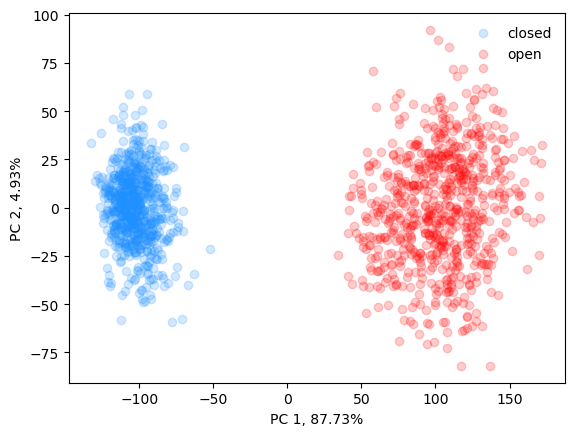

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(proj_closed[:, 0], proj_closed[:, 1], alpha=0.2, color="dodgerblue", label="closed")
ax.scatter(proj_open[:, 0], proj_open[:, 1], alpha=0.2, color="red", label="open")
ax.set_xlabel(f'PC 1, {pca.explained_variance_ratio_[0]*100:3.2f}%')
ax.set_ylabel(f'PC 2, {pca.explained_variance_ratio_[1]*100:3.2f}%')
ax.legend(frameon=False)

<div class="alert alert-success">
<b>Task 1.</b> Discuss: Do PC1 and PC2 give you well-separated clusters? What does this tell us about the features we extracted? Do you need more dimensions to obtain a better separation?</div>

<details>
<summary> <mark> Answer 1</mark> </summary>
If the open and closed state are well-separated in the 2D projection, this means that the features selected are highly correlated.
</details>

## 4. Training a Random Forests classifier on input data <a id="training"></a>

Let's start by training a [Random Forests Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) (RF) using the training set we have just assembled. The RF is constituted by a collection of decision trees, each trained on a subset of data ("data bagging") and subset of features ("features bagging"). The key philosophy behind RF is that a collection of weak classifiers (here, decision trees) makes a strong classifier. After training, classification is done by voting: each decision tree proposes a classification, and the most voted class wins. A key advantage of this approah, is that RF does not overfit. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(n_estimators=10)
RF.fit(train_set, train_class)

Let's now assess its performance against the test set.

In [ ]:
r = RF.predict(test_set)
success = np.sum((r-test_class)==0)
percent = float(success)/len(test_class)*100
print(f'Success of test set: {percent}%')

To see which features are deemed the most useful for a successful classification, we can observe their importance.

In [ ]:
importances = RF.feature_importances_
importances_std = np.std([tree.feature_importances_ for tree in RF.estimators_], axis=0)

if F.feature == "coordinates":

    ca = universe_closed.select_atoms('name CA')[int(np.argmax(importances)/3)]
    print(f'Most relevant amino acid: {ca.resname}{ca.resid}')


elif F.feature == "distance matrix": 

    # get indices of most important CA atoms pair
    na = len(universe_closed.select_atoms('name CA'))
    pos = np.array(np.triu_indices(na))[:, np.argmax(importances)].T

    # retrieve their identity
    ca1 = universe_closed.select_atoms('name CA')[pos[0]]
    ca2 = universe_closed.select_atoms('name CA')[pos[1]]
    print(f'Most relevant distance: {ca1.resname}{ca1.resid} - {ca2.resname}{ca2.resid}')
    

<div class="alert alert-success">
<b>Task 2.</b> Run Section 4 again from the beginning. Is the most relevant feature always the same? Why?</div>

<details>
<summary> <mark> Answer 2</mark> </summary>
Training the Random Forests classifier again will give different results because the training process is stochastic, and thus it will converge to different models. Their performance will be likely comparable, because there normally exist multiple models  performing equally comparatively well in a classification task.</details>

## 5. Classification of conformations from new simulation

It is now time to characterize the simulation of the trajectory showing a switch from the closed to the open state.

In [ ]:
feat_closed_apo = F.get_features(universe_closed_apo)
r = RF.predict(feat_closed_apo)

Let's have a look at the classification. This can be done with a simple colorbar, where different colours represent different classes.

In [ ]:
fig = plt.figure(1, figsize=(10, 1))
ax = fig.add_subplot(1, 1, 1)
ax.pcolormesh([r]) #purple = closed, yellow = open
ax.set_yticks([])
ax.set_xlabel("conformation / #")

Let's compare the three datasets (closed, open, and open apo) according to the value most important feature according to the classifier.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(np.arange(len(feat_closed))/10., feat_closed[:, np.argmax(importances)], label="closed", color="dodgerblue")
ax.plot(np.arange(len(feat_open))/10., feat_open[:, np.argmax(importances)], label="open", color="orangered")
ax.plot(np.arange(len(feat_closed_apo))/10., feat_closed_apo[:, np.argmax(importances)], label="closed apo", color="#682860")

ax.set_xlabel("time / ns")
ax.set_ylabel("distance / $\AA$")
ax.legend(frameon=False)

The closed apo simulation appears to take values in its most important feature different from anything seen in the training set. Here we will carry out an outlied detection using an Isolation Forest. More information about outlier detection is available [here](https://scikit-learn.org/stable/modules/outlier_detection.html). The following cell may take some time to run (a few minutes).

In [ ]:
from sklearn.ensemble import IsolationForest

clf = IsolationForest(n_estimators=10, warm_start=True)
clf.fit(train_set)

y_closed_apo = clf.predict(feat_closed_apo) # 1 = inliers, -1 = outliers

In [ ]:
fig = plt.figure(1, figsize=(10, 1))
ax = fig.add_subplot(1, 1, 1)
ax.pcolormesh([y_closed_apo])
ax.set_yticks([])
ax.set_xlabel("conformation / #")

<div class="alert alert-success">
<b>Task 3.</b> There seem to be quite a few outliers, what does this tell us about the closed apo simulation?</div>

<details>
<summary> <mark> Answer 3</mark> </summary>
The classification we obtained tells us that the second part of the simulation is more similar to the open than the closed state, however its conformations are not consistent with those sampled by the open simulations.</details>

Let's observe how the most relevant feature measured in the closed apo simulation relates to that of closed and open simulations in the eigenspace of the PCA projection. We will show the closed and open simulation in light gray, and the closed apo conformation with a colour gradient showing, from dark to light, the time evolution.

In [ ]:
proj_closed_apo = pca.transform(feat_closed_apo)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(proj_closed[:, 0], proj_closed[:, 1], alpha=0.4, c="lightgrey")
ax.scatter(proj_open[:, 0], proj_open[:, 1], alpha=0.4, c="lightgrey")
ax.scatter(proj_closed_apo[:, 0], proj_closed_apo[:, 1], alpha=0.5, c=np.arange(len(proj_closed_apo))) 
ax.set_xlabel(f'PC 1, {pca.explained_variance_ratio_[0]*100:3.2f}%')
ax.set_ylabel(f'PC 2, {pca.explained_variance_ratio_[1]*100:3.2f}%')

A problem of using directly coordinates as a feature, is that results will depend on how the simulations are aligned: different alignments would lead to different results. If the trajectories were not aligned at all, using coordinates would not work because the signal would be dominated by the rototranslation of the whole protein as it randomly diffuses through the simulation box. For this reason, selecting features that are rototranslation invariant is advantageous. An example of such feature, is backbone dihedral angles.

<div class="alert alert-success">
<b>Task 4.</b> In Section 2 we have defined the class <code>Featurizer</code>, defining different methods to extract features from an MDAnalysis Universe. The class was used in the first cell of Section 3. Run again this notebook from Section 3, setting  <code>feature_type = "ramachandran"</code> and <code>feature_type = "distance matrix"</code>. What do you notice?</div>

<details>
<summary> <mark> Answer 4</mark> </summary>
Using the backbone dihedral angles seems to work according to the PCA, but classification fails to identify two states.
</details>

## 6. Extra material: hyperparameter tuning

In this tutorial, it was relatively easy to train a classifier able to separate the two classes: in all cases, the classification of the test set yielded high success rates. This may not always be the case though. In more difficult cases there are two things one could try to improve the success rate. The first, as explored in this tutorial, is identifying better features. The second, is **hyparameter tuning**.

Any classifier is controlled by a series of parameters. In this tutorial we have defined one, the number of trees (`n_estimators`). This said, several other values could have been chosen for this parameter as well as others for which we used defaults (e.g. the maximal depth of each tree `max_depth`, or minimum number of samples a leaf can contain `min_samples_leaf`). 

Scikit-learn provides tools to train a classifier multiple times, with different sets of parameters, identifying the combination leading to best performances.

In [ ]:
from sklearn.model_selection import GridSearchCV

#define classifier
rf = RandomForestClassifier()

# define parameters and values to test
params = {
    'max_depth': [2, 3, 5, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100, 200],
    'n_estimators': [10, 25, 30, 50, 100, 200]
}

# grid search over parameters space
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(train_set, train_class)

# best estimator found with grid search
RF_best = grid_search.best_estimator_

## 7. Conclusion 

<div class="alert alert-info">
    <b>Key points:</b>   

- Classification is an example of supervised learning
- the choice of features extracted from raw data can affect the classification results
- Random Forests is a popular classification algorithm. Its key advantages are that it does not overfit, and can handle a very large number of features
- Be mindful of outliers
</div>

---